# Size of images  at USDF 

In [51]:
# This cell is only for setting parameter defaults
day = "20260104"
instrument = 'LSSTCam'

In [52]:
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import Registry
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time, TimeDelta
import boto3.session
from datetime import datetime, timezone
import  astropy.units as u

repo = 'embargo'
dt = 'raw'
# raw all collection contains all images 
collections = [f'{instrument}/raw/all']
butler = Butler(repo, collections=collections, instrument=instrument)
where = f"day_obs={day}"

endpoint_url = "https://sdfembs3.sdf.slac.stanford.edu/"
boto_profile = "embargo"

day_obs = int(day)
days = [day_obs, 20260105, 20260106, 20260107]



# Data transferred and ingested in butler and access to data



In [53]:
uri = {}
for day_obs in days :
    result = butler.query_datasets( dt, limit=None, 
        where = f" day_obs = {day_obs} ", order_by = "exposure")
    print (f"Got {len(result)} images  {instrument} images on day_obs={day}")
    uri = uri | butler._datastore.getManyURIs(result)
    


Got 148932 images  LSSTCam images on day_obs=20260104
Got 70132 images  LSSTCam images on day_obs=20260104
Got 19109 images  LSSTCam images on day_obs=20260104
Got 128050 images  LSSTCam images on day_obs=20260104


### size ..
Ge the size on disk for each image  - may need to find out if its a Bias/Calib/real image

In [54]:
from lsst.resources import ResourcePath
print (len(uri))
sizes = np.empty(shape = [len(uri)]) 
min=20 
max=0
exposuresizes={}

for count,key in enumerate(uri.keys()):
    ref = uri[key]
    exp = key.dataId['exposure']
    if exp not in exposuresizes:
        exposuresizes[exp]= 0
    resource = ref.primaryURI
    # Check if it exists
    if resource.exists():
       size_bytes = resource.size()
       sizes[count]= size_bytes/(1000*1000) # in MB
       if sizes[count] > max:
           max = sizes[count]
           print(f"Max:{max} at {count}")
       if sizes[count] < min:
           min = sizes[count]
           print(f"Min:{min} at {count}")
       exposuresizes[exp] += sizes[count]
    else:
       print("Resource does not exist.")

366223
Max:11.63808 at 0
Min:11.63808 at 0
Max:11.85408 at 1
Max:12.15936 at 2
Max:12.74688 at 5
Max:13.25952 at 17
Min:7.29504 at 46
Max:14.184 at 48
Min:7.29216 at 1579
Min:7.28928 at 1821
Max:14.18688 at 3434
Max:14.18976 at 11418
Max:14.2272 at 11572
Max:14.23008 at 11660
Max:14.23296 at 12366
Max:14.23584 at 12501
Max:14.23872 at 12641
Max:14.24736 at 12935
Max:23.45184 at 13199
Max:24.54912 at 13201
Max:24.7536 at 13222
Max:25.56 at 13224
Max:26.41824 at 13312


In [55]:
exps = list(exposuresizes.values())
print (f"{len(exps)} Exposures")
mean = np.mean(exps) / 1000 
min = np.min(exps) / 1000 
max = np.max(exps) / 1000 
std = np.std(exps) / 1000
sum = np.sum(exps) 
avetb = sum / (1000*1000) / len (days)

print(f"Exposures: Min:{min:.2f} Max:{max:.2f} Mean:{mean:.2f} Standard deviation:{std:.2f} (GB)   ave night:{avetb:.2f}TB")

1859 Exposures
Exposures: Min:2.01 Max:4.57 Mean:3.52 Standard deviation:0.59 (GB)   ave night:1.64TB


In [56]:
mean = np.mean(sizes)
min = np.min(sizes)
max = np.max(sizes)
std = np.std(sizes)
sum = np.sum(sizes) 
avetb = sum / (1000*1000) / len (days)

print(f"CCDs Min:{min:.2f} Max:{max:.2f} Mean:{mean:.2f} Standard deviation:{std:.2f} (MB)   ave night:{avetb:.2f}TB")

CCDs Min:7.29 Max:26.42 Mean:17.89 Standard deviation:3.49 (MB)   ave night:1.64TB


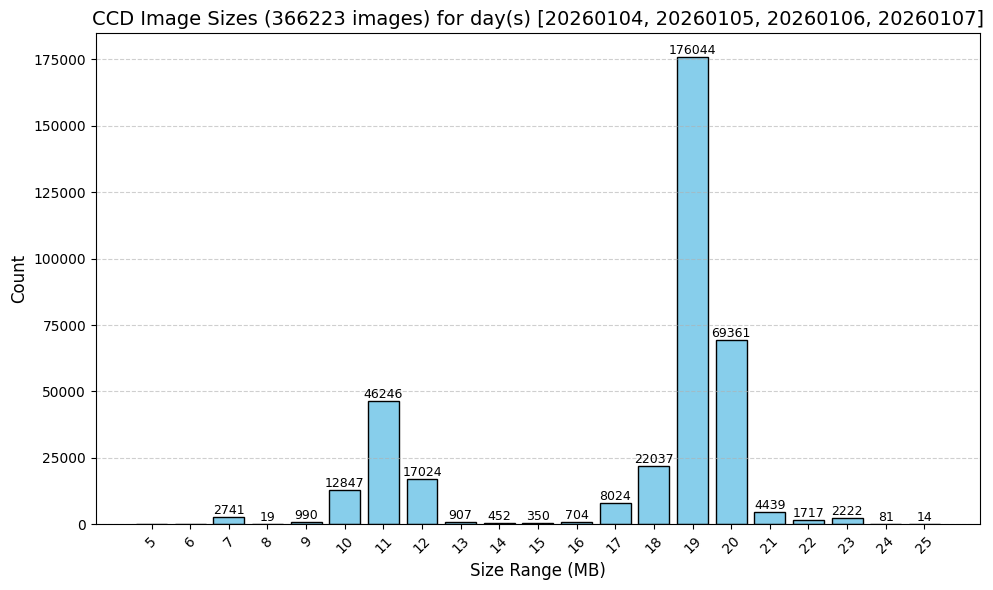

In [57]:
import numpy as np
import matplotlib.pyplot as plt


bins =  list(range(5, 27))
# Compute histogram
hist, edges = np.histogram(sizes, bins=bins)

# Create bin labels int
bin_labels = [f"{int(edges[i])}" for i in range(len(edges)-1)]
# Plot histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(bin_labels, hist, width=0.8, edgecolor='black', color='skyblue')
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(height),
                 ha='center', va='bottom', fontsize=9)

# Labels and title
plt.xlabel("Size Range (MB)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"CCD Image Sizes ({len(sizes)} images) for day(s) {days}", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [58]:
from sklearn.mixture import GaussianMixture

# Reshape for sklearn
X = sizes.reshape(-1, 1)

# Fit GMM with 2 components
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(X)

# Extract means
means = gmm.means_.flatten()
# Sort for readability
means = np.sort(means)

print("Estimated means for CCD image size(MB):", means)

Estimated means for CCD image size(MB): [11.56012075 19.70186576]


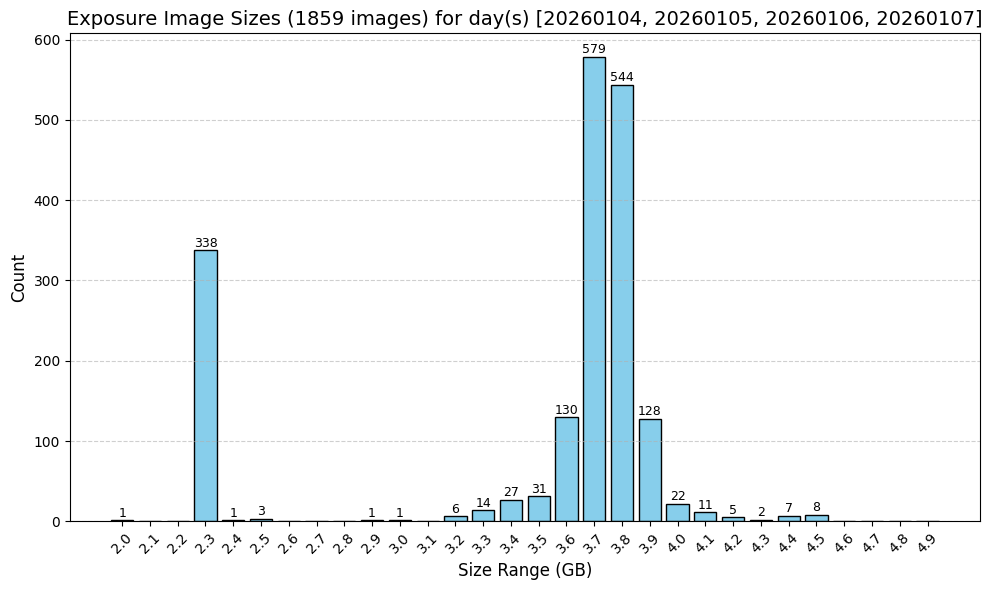

In [69]:
#sizes of exposures as GB
esize = np.asarray(exps, dtype=float) / 1000
start, stop, step = 2.0, 5.0, 0.2
bins = [i / 10 for i in range(int(start*10), int(stop*10) + 1)]
#bins =  list(range(2, 6)) 
# Compute histogram
hist, edges = np.histogram(esize, bins=bins)

# Create bin labels int
#bin_labels = [f"{int(edges[i])}" for i in range(len(edges)-1)]
bin_labels = [f"{(edges[i]):.1f}" for i in range(len(edges)-1)]

# Plot histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(bin_labels, hist, width=0.8, edgecolor='black', color='skyblue')
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(height),
                 ha='center', va='bottom', fontsize=9)

# Labels and title
plt.xlabel("Size Range (GB)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title(f"Exposure Image Sizes ({len(exps)} images) for day(s) {days}", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [60]:

# Reshape for sklearn
X = esize.reshape(-1, 1)

# Fit GMM with 2 components
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(X)

# Extract means
means = gmm.means_.flatten()
# Sort for readability
means = np.sort(means)

print("Estimated means for Exposure size(GB):", means)

Estimated means for Exposure size(GB): [2.31729256 3.78920204]
